# Purpose

2022-07(update):
Check more params to see if there are some parameters we can exclude (because they always result in outputs with low performance).

Parmeters to check:
- cluster_linkage
- distance metric (`cluster__affinity`)
- SVD step (apply SVD before clustering)

---
2022-02
After fixing the parallel jobs, we need to pick the best model to share on bigQuery and to use for new FPRs.


# Imports & Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from datetime import datetime
import logging
import os
from pathlib import Path

import numpy as np
import pandas as pd
import plotly
import plotly.express as px
import seaborn as sns

import mlflow
import hydra

import subclu
from subclu.eda.aggregates import compare_raw_v_weighted_language
from subclu.utils import set_working_directory, get_project_subfolder
from subclu.utils.eda import (
    setup_logging, counts_describe, value_counts_and_pcts,
    notebook_display_config, print_lib_versions,
    style_df_numeric, reorder_array,
)
from subclu.utils.mlflow_logger import MlflowLogger
from subclu.utils.hydra_config_loader import LoadHydraConfig
from subclu.utils.data_irl_style import (
    get_colormap, theme_dirl, 
    get_color_dict, base_colors_for_manual_labels,
    check_colors_used,
)
from subclu.data.data_loaders import LoadPosts, LoadSubreddits, create_sub_level_aggregates


# ===
# imports specific to this notebook



print_lib_versions([hydra, np, pd, plotly, sns, subclu])

python		v 3.7.10
===
hydra		v: 1.1.0
numpy		v: 1.19.5
pandas		v: 1.2.4
plotly		v: 4.14.3
seaborn		v: 0.11.1
subclu		v: 0.5.0


In [3]:
# plotting
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.dates as mdates
plt.style.use('default')

setup_logging()
notebook_display_config()

# Set sqlite database as MLflow URI

In [4]:
# use new class to initialize mlflow
mlf = MlflowLogger(tracking_uri='sqlite')
mlflow.get_tracking_uri()

'sqlite:////home/jupyter/subreddit_clustering_i18n/mlflow_sync/djb-100-2021-04-28-djb-eda-german-subs/mlruns.db'

## Get list of experiments with new function

In [5]:
mlf.list_experiment_meta(output_format='pandas').tail(9)

,experiment_id,name,artifact_location,lifecycle_stage
25,25,v0.4.1_mUSE_clustering_new_metrics,gs://i18n-subreddit-clustering/mlflow/mlruns/25,active
26,26,v0.4.1_nearest_neighbors_test,gs://i18n-subreddit-clustering/mlflow/mlruns/26,active
27,27,v0.4.1_nearest_neighbors,gs://i18n-subreddit-clustering/mlflow/mlruns/27,active
28,28,v0.5.0_mUSE_aggregates_test,gs://i18n-subreddit-clustering/mlflow/mlruns/28,active
29,29,v0.5.0_mUSE_aggregates,gs://i18n-subreddit-clustering/mlflow/mlruns/29,active
30,30,v0.5.0_mUSE_clustering_test,gs://i18n-subreddit-clustering/mlflow/mlruns/30,active
31,31,v0.5.0_mUSE_clustering,gs://i18n-subreddit-clustering/mlflow/mlruns/31,active
32,32,v0.5.0_nearest_neighbors_test,gs://i18n-subreddit-clustering/mlflow/mlruns/32,active
33,33,v0.5.0_nearest_neighbors,gs://i18n-subreddit-clustering/mlflow/mlruns/33,active


## Get experiment ID's for models to check

experiment ID 25 as the latest runs

In [6]:
%%time

df_mlf = mlf.search_all_runs(experiment_ids=[31])
df_mlf.shape

CPU times: user 502 ms, sys: 37.4 ms, total: 540 ms
Wall time: 539 ms


(36, 283)

In [7]:
df_mlf.iloc[:5, :10]

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.vectorizing_time_minutes,metrics.primary_topic-0020_to_0040-adjusted_mutual_info_score,metrics.primary_topic-0060_to_0070-f1_score-macro_avg,metrics.primary_topic-0040_to_0050-adjusted_mutual_info_score
0,45579150ddd74fd5a1235f4fb922b9c5,31,FINISHED,gs://i18n-subreddit-clustering/mlflow/mlruns/31/45579150ddd74fd5a1235f4fb922b9c5/artifacts,2022-07-06 19:28:01.754000+00:00,2022-07-06 19:47:07.449000+00:00,19.087653,0.000192,0.011962,0.002218
1,490036d3460944d0b69954e70e7fbe5e,31,FINISHED,gs://i18n-subreddit-clustering/mlflow/mlruns/31/490036d3460944d0b69954e70e7fbe5e/artifacts,2022-07-06 19:26:51.505000+00:00,2022-07-06 20:08:56.844000+00:00,42.082536,0.000194,0.009431,0.000232
2,74e31ac53aa7459f895a491aa6f020ad,31,FINISHED,gs://i18n-subreddit-clustering/mlflow/mlruns/31/74e31ac53aa7459f895a491aa6f020ad/artifacts,2022-07-06 19:25:49.241000+00:00,2022-07-06 19:43:44.038000+00:00,17.906991,0.000194,0.011494,0.001815
3,7316cbfae403413da5a97af2937b45ad,31,FINISHED,gs://i18n-subreddit-clustering/mlflow/mlruns/31/7316cbfae403413da5a97af2937b45ad/artifacts,2022-07-06 19:25:41.543000+00:00,2022-07-06 20:09:18.335000+00:00,43.606920,0.000082,0.009403,0.000232
4,ea99614dd89a466c9251bf2f295ebeb8,31,FINISHED,gs://i18n-subreddit-clustering/mlflow/mlruns/31/ea99614dd89a466c9251bf2f295ebeb8/artifacts,2022-07-06 19:24:57.824000+00:00,2022-07-06 19:42:53.623000+00:00,17.923716,0.000480,0.012083,0.000828


In [8]:
mask_finished = df_mlf['status'] == 'FINISHED'
mask_score_complete = ~df_mlf['metrics.primary_topic-2350_to_2700-f1_score-weighted_avg'].isnull()

df_mlf_clustering_candidates = df_mlf[mask_finished & mask_score_complete]
df_mlf_clustering_candidates.shape

(36, 283)

In [9]:
cols_with_multiple_vals = df_mlf_clustering_candidates.columns[df_mlf_clustering_candidates.nunique(dropna=False) > 1]
print(f"interesting cols: {len(cols_with_multiple_vals)}")
df_mlf_clustering_candidates[cols_with_multiple_vals].iloc[:5, :10]

interesting cols: 255


,run_id,artifact_uri,start_time,end_time,metrics.vectorizing_time_minutes,metrics.primary_topic-0020_to_0040-adjusted_mutual_info_score,metrics.primary_topic-0060_to_0070-f1_score-macro_avg,metrics.primary_topic-0040_to_0050-adjusted_mutual_info_score,metrics.primary_topic-3800_to_3900-f1_score-macro_avg,metrics.primary_topic-0010_to_0020-adjusted_mutual_info_score
0,45579150ddd74fd5a1235f4fb922b9c5,gs://i18n-subreddit-clustering/mlflow/mlruns/31/45579150ddd74fd5a1235f4fb922b9c5/artifacts,2022-07-06 19:28:01.754000+00:00,2022-07-06 19:47:07.449000+00:00,19.087653,0.000192,0.011962,0.002218,0.487702,0.000165
1,490036d3460944d0b69954e70e7fbe5e,gs://i18n-subreddit-clustering/mlflow/mlruns/31/490036d3460944d0b69954e70e7fbe5e/artifacts,2022-07-06 19:26:51.505000+00:00,2022-07-06 20:08:56.844000+00:00,42.082536,0.000194,0.009431,0.000232,0.382857,0.000061
2,74e31ac53aa7459f895a491aa6f020ad,gs://i18n-subreddit-clustering/mlflow/mlruns/31/74e31ac53aa7459f895a491aa6f020ad/artifacts,2022-07-06 19:25:49.241000+00:00,2022-07-06 19:43:44.038000+00:00,17.906991,0.000194,0.011494,0.001815,0.495924,0.000104
3,7316cbfae403413da5a97af2937b45ad,gs://i18n-subreddit-clustering/mlflow/mlruns/31/7316cbfae403413da5a97af2937b45ad/artifacts,2022-07-06 19:25:41.543000+00:00,2022-07-06 20:09:18.335000+00:00,43.606920,0.000082,0.009403,0.000232,0.374143,0.000061
4,ea99614dd89a466c9251bf2f295ebeb8,gs://i18n-subreddit-clustering/mlflow/mlruns/31/ea99614dd89a466c9251bf2f295ebeb8/artifacts,2022-07-06 19:24:57.824000+00:00,2022-07-06 19:42:53.623000+00:00,17.923716,0.000480,0.012083,0.000828,0.488645,0.000139


# EDA parameters to check

Parmeters to check:
- cluster_linkage (`params._pipe-cluster__linkage`)
- distance metric (`params._pipe-cluster__affinity`)
- SVD step (apply SVD before clustering)
    - `params._pipe-reduce__n_components` (`Null` or `None` => No SVD reduction)
    
Note: `Normalize l2` is only applied to `ward` because:
- `l2-norm+euclidean distance = cosine distance`
`sklearn`'s implementation of `ward` only works with cosine distance, so we need to make this tweak in order to get cosine distance (which is better for our use case).

---
Note 2:
It looks like there is a but in the `SVD` / Reduction step because `n_components` always equals 2.  It should be `50`.

In [10]:
[c for c in df_mlf_clustering_candidates.columns if 'filter' in c]

['metrics.filtered_embeddings-n_rows', 'metrics.filtered_embeddings-n_cols']

In [11]:
# [c for c in df_mlf_clustering_candidates.columns if 'min' in c]

In [12]:
l_parallel_params = [
    # 'metrics.filtered_embeddings-n_rows',  # Might not be a parameter to tune anymore (n_minimumn # of posts in subreddit)
    'params._pipe-normalize__norm', 
    'params._pipe-reduce__n_components',
    'params._pipe-cluster__affinity',
    'metrics.filtered_embeddings-n_rows',
    'params._pipe-cluster__linkage',
]

for c_ in l_parallel_params:
    display(
        value_counts_and_pcts(
            df_mlf_clustering_candidates,
            [c_]
        )
    )

,count,percent,cumulative_percent
params._pipe-normalize__norm,,,
null,30,83.3%,83.3%
l2,6,16.7%,100.0%


,count,percent,cumulative_percent
params._pipe-reduce__n_components,,,
128,18,50.0%,50.0%
null,18,50.0%,100.0%


,count,percent,cumulative_percent
params._pipe-cluster__affinity,,,
euclidean,24,66.7%,66.7%
cosine,12,33.3%,100.0%


,count,percent,cumulative_percent
metrics.filtered_embeddings-n_rows,,,
81815.0,12,33.3%,33.3%
81954.0,12,33.3%,66.7%
81970.0,12,33.3%,100.0%


,count,percent,cumulative_percent
params._pipe-cluster__linkage,,,
average,12,33.3%,33.3%
complete,12,33.3%,66.7%
ward,12,33.3%,100.0%


In [44]:
d_linkage_to_num = {
    'ward': 4,
    'complete': 3,
    'average': 2,
    'single': 1,
}
d_num_to_linkage = {v: k for k, v in d_linkage_to_num.items()}
print(d_num_to_linkage)

d_affinity_to_num = {
    'cosine': 2,
    'euclidean': 1,
}
d_num_to_affinity = {v: k for k, v in d_affinity_to_num.items()}
print(d_num_to_affinity)

d_norm_to_num = {
    'l2': 2,
    'None': 1,
}
d_num_to_norm = {v: k for k, v in d_norm_to_num.items()}
print(d_num_to_norm)

d_comp_to_num = {
    "None": 512,
    2: 2,
    50: 50
}
d_num_to_comp = {v: k for k, v in d_comp_to_num.items()}
print(d_num_to_comp)

{4: 'ward', 3: 'complete', 2: 'average', 1: 'single'}
{2: 'cosine', 1: 'euclidean'}
{2: 'l2', 1: 'None'}
{512: 'None', 2: 2, 50: 50}


In [45]:
c_subreddits_filtered = 'metrics.filtered_embeddings-n_rows'

value_counts_and_pcts(
    df_mlf_clustering_candidates,
    [c for c in l_parallel_params if c_subreddits_filtered not in c],
    sort_index=True,
    cumsum=False,
)

In [46]:
value_counts_and_pcts(
    df_mlf_clustering_candidates,
    [c_subreddits_filtered],
    sort_index=True,
    cumsum=False,
)

,count,percent
metrics.filtered_embeddings-n_rows,,
81815.0,12,33.3%
81954.0,12,33.3%
81970.0,12,33.3%


In [47]:
# l_all_pipe_params = sorted([c for c in df_mlf_clustering_candidates.columns if 'params._pipe' in c])
# df_mlf_clustering_candidates[l_all_pipe_params].head()

In [48]:
# sorted([c for c in df_mlf_clustering_candidates.columns if 'distance' in c])

# Pick primary metric cols for evaluation & visualize in parallel coordinates plot

We want to keep the model that:
- has the highest metric scores
- covers the largest number of subreddits (rows)

One hyperparameter while creating clusters is filtering out subreddits with too few posts (min posts). Sometimes these can add noise and impact clustering upstream.

params:
- linkage type
- number of subreddits (rows) after filtering
 
metrics:
- Optimal clusters to check:
    - @ 3000 to 3200
    - @ 3900 to 4000
- metrics
    - f1 weighted
    - adjusted mutual info
    - adjusted rand score
    - homogeneity

In [49]:
def rename_col_for_display(
    col_name: str,
) -> str:
    """
    Remove prefixes & other extra characters to columns so 
    that it's easier to read/display them in plots & tables
    """
    return (
        col_name
        .replace('metrics.primary_topic-', '')
        .replace('00-', '00<br>')  # split cols into 2 rows after num of clusters (k)
        .replace('filtered_embeddings-n_rows', 'subreddits')  # subreddits clustered
        .replace('_score', '_score<br>') # add an extra break after avg & score to improve look of plots
        .replace('_avg', '_avg<br><br>')
        .replace('metrics.', '')
        .replace('params.', '')
        .replace('_pipe-', '')
        .replace('__', '_')
        .replace('_', ' ')
    )

In [50]:
sorted([rename_col_for_display(c) for c in l_parallel_params])

['cluster affinity',
 'cluster linkage',
 'normalize norm',
 'reduce n components',
 'subreddits']

In [51]:
# sorted([c for c in df_mlf_clustering_candidates.columns if '3000' in c])

In [52]:
# sorted([c for c in df_mlf_clustering_candidates.columns if '4000' in c])

In [53]:
# sorted([rename_col_for_display(c) for c in df_mlf_clustering_candidates.columns if '4000' in c])

In [54]:
# [c for c in df_mlf_clustering_candidates.columns if 'metric' in c][-15:]

For now forget linkage type, there's some weird thing where you can't show text or category dtypes in a parallel coordinate plot (unless you convert the values to numbers).
- https://github.com/plotly/plotly.py/issues/2494

Looks like you could use the lower-level `go.Parcoords` to do it, but at this point that's too much for me (maybe this is what mlflow uses under the hood?).
- https://plotly.com/python/parallel-coordinates-plot/#parallel-coordinates-chart-with-goparcoords


---
NOTE: plotly uses a df's index, so make sure to reset index b/c otherwise we can end up with weird results!

In [55]:

l_parallel_metrics_3k = [
    # 'metrics.primary_topic-3000_to_3200-homogeneity_score',
    'metrics.primary_topic-3000_to_3200-adjusted_mutual_info_score',
    # 'metrics.primary_topic-3000_to_3200-adjusted_rand_score',
    'metrics.primary_topic-3000_to_3200-f1_score-weighted_avg',
]
l_parallel_metrics_4k = [
    # 'metrics.primary_topic-3900_to_4000-homogeneity_score',
    'metrics.primary_topic-3900_to_4000-adjusted_mutual_info_score',
    # 'metrics.primary_topic-3900_to_4000-adjusted_rand_score',
    'metrics.primary_topic-3900_to_4000-f1_score-weighted_avg',
]

l_parallel_metrics_all = l_parallel_metrics_3k + l_parallel_metrics_4k

In [74]:
# l_cols_plot_raw_ = l_parallel_params + l_parallel_metrics_3k
# l_cols_plot_clean_ = [rename_col_for_display(c) for c in l_cols_plot_raw_]
# df_plot_ = (
#     df_mlf_clustering_candidates[l_cols_plot_raw_]
#     .fillna({'params._pipe-reduce__n_components': 512, 'params._pipe-normalize__norm': 'None'})  # for SVD nulls & norm nulls
#     .rename(columns={c: rename_col_for_display(c) for c in l_cols_plot_raw_})
#     .reset_index(drop=True)
# )
# # remap cluster linkage so it shows up in plot
# col_linkage_clean = 'cluster linkage'
# col_affinity_clean = 'cluster affinity'
# col_comp_clean = 'reduce n components'
# col_norm_clean = 'normalize norm'
# df_plot_[col_linkage_clean] = df_plot_[col_linkage_clean].replace(d_linkage_to_num)
# df_plot_[col_affinity_clean] = df_plot_[col_affinity_clean].replace(d_affinity_to_num)
# df_plot_[col_comp_clean] = df_plot_[col_comp_clean].astype(int).replace(d_comp_to_num)
# df_plot_[col_norm_clean] = df_plot_[col_norm_clean].replace(d_norm_to_num)
# print(f"Linkage names:\n  {d_num_to_linkage}")
# print(f"Affinity names:\n  {d_num_to_affinity}")
# print(f"Component names:\n  {d_num_to_comp}")
# print(f"Norm names:\n  {d_num_to_norm}")

# fig = px.parallel_coordinates(
#     df_plot_,
#     color=l_cols_plot_clean_[-1],
#     # dimensions=l_cols_plot_clean_,
#     # labels={},
#     # color_continuous_scale=px.colors.diverging.Tealrose,
#     # color_continuous_midpoint=2
# )
# fig.show()

Plot w/o normalized norm (it only changes `ward` linkage)

Linkage names:
  {4: 'ward', 3: 'complete', 2: 'average', 1: 'single'}
Affinity names:
  {2: 'cosine', 1: 'euclidean'}
Component names:
  {512: 'None', 2: 2, 50: 50}


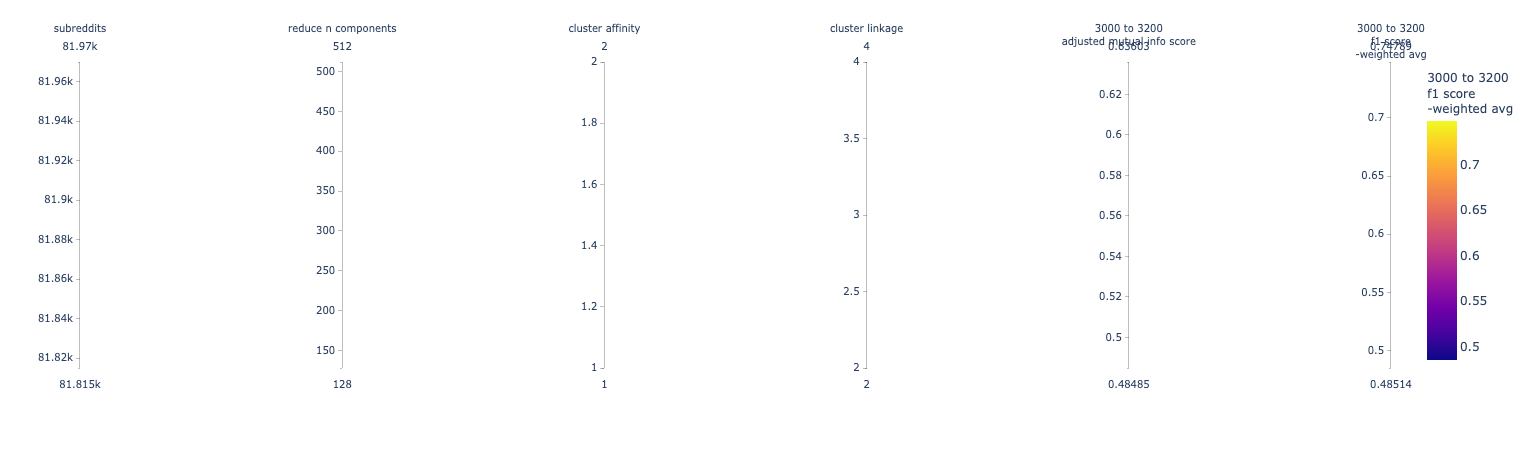

In [57]:
l_cols_plot_raw_ = l_parallel_params + l_parallel_metrics_3k
l_cols_plot_clean_ = [rename_col_for_display(c) for c in l_cols_plot_raw_]
df_plot_ = (
    df_mlf_clustering_candidates[l_cols_plot_raw_]
    .fillna({'params._pipe-reduce__n_components': 512})  # for SVD nulls
    .rename(columns={c: rename_col_for_display(c) for c in l_cols_plot_raw_})
    .reset_index(drop=True)
)
# remap cluster linkage so it shows up in plot
col_linkage_clean = 'cluster linkage'
col_affinity_clean = 'cluster affinity'
col_comp_clean = 'reduce n components'
df_plot_[col_linkage_clean] = df_plot_[col_linkage_clean].replace(d_linkage_to_num)
df_plot_[col_affinity_clean] = df_plot_[col_affinity_clean].replace(d_affinity_to_num)
df_plot_[col_comp_clean] = df_plot_[col_comp_clean].astype(int).replace(d_comp_to_num)
print(f"Linkage names:\n  {d_num_to_linkage}")
print(f"Affinity names:\n  {d_num_to_affinity}")
print(f"Component names:\n  {d_num_to_comp}")

# df_plot_ = df_plot_.drop('subreddits', axis=1)
fig = px.parallel_coordinates(
    df_plot_,
    color=l_cols_plot_clean_[-1],
    # dimensions=l_cols_plot_clean_,
    # labels={},
    # color_continuous_scale=px.colors.diverging.Tealrose,
    # color_continuous_midpoint=2
)
fig.show()

Check score at k=4000m

Linkage names:
  {4: 'ward', 3: 'complete', 2: 'average', 1: 'single'}
Affinity names:
  {2: 'cosine', 1: 'euclidean'}
Component names:
  {512: 'None', 2: 2, 50: 50}


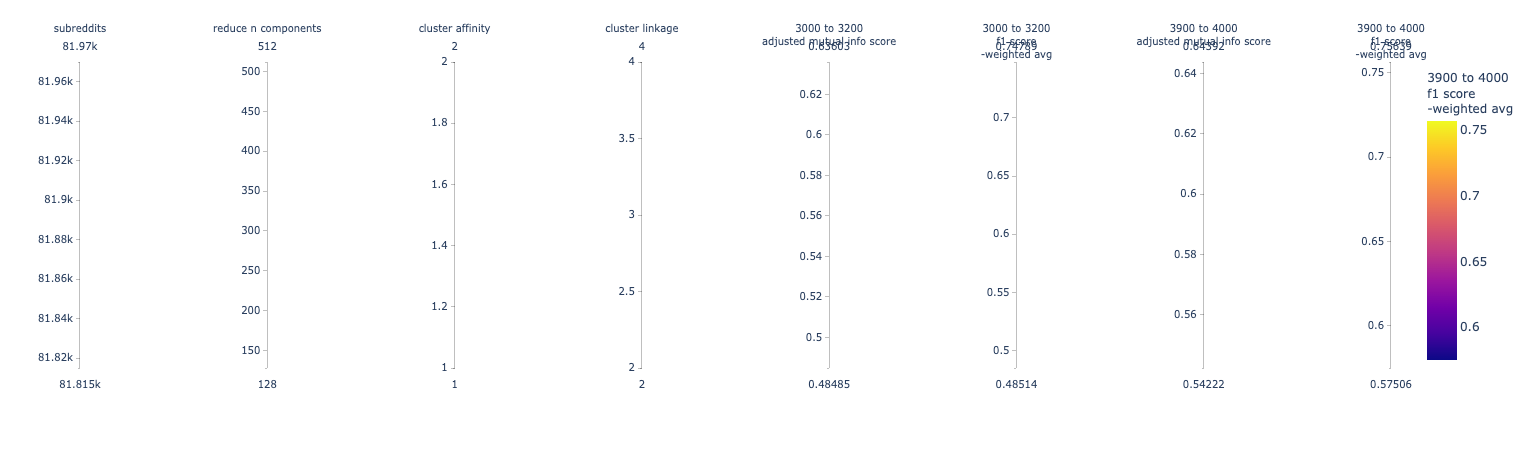

In [58]:
l_cols_plot_raw_ = l_parallel_params + l_parallel_metrics_3k + l_parallel_metrics_4k
l_cols_plot_clean_ = [rename_col_for_display(c) for c in l_cols_plot_raw_]
df_plot_ = (
    df_mlf_clustering_candidates[l_cols_plot_raw_]
    .fillna({'params._pipe-reduce__n_components': 512})  # for SVD nulls
    .rename(columns={c: rename_col_for_display(c) for c in l_cols_plot_raw_})
    .reset_index(drop=True)
)
# remap cluster linkage so it shows up in plot
col_linkage_clean = 'cluster linkage'
col_affinity_clean = 'cluster affinity'
col_comp_clean = 'reduce n components'
df_plot_[col_linkage_clean] = df_plot_[col_linkage_clean].replace(d_linkage_to_num)
df_plot_[col_affinity_clean] = df_plot_[col_affinity_clean].replace(d_affinity_to_num)
df_plot_[col_comp_clean] = df_plot_[col_comp_clean].astype(int).replace(d_comp_to_num)
print(f"Linkage names:\n  {d_num_to_linkage}")
print(f"Affinity names:\n  {d_num_to_affinity}")
print(f"Component names:\n  {d_num_to_comp}")


fig = px.parallel_coordinates(
    df_plot_,
    color=l_cols_plot_clean_[-1],
    # dimensions=l_cols_plot_clean_,
    # labels={},
    # color_continuous_scale=px.colors.diverging.Tealrose,
    # color_continuous_midpoint=2
)
fig.show()

## Exclude runs lowest performing runs

Remove the worst runs to better understand the parameters driving the high-value runs.

remember to `.reset_index()` after flintering (before plotting)!

Linkage names:
  {4: 'ward', 3: 'complete', 2: 'average', 1: 'single'}
Affinity names:
  {2: 'cosine', 1: 'euclidean'}
Component names:
  {512: 'None', 2: 2, 50: 50}


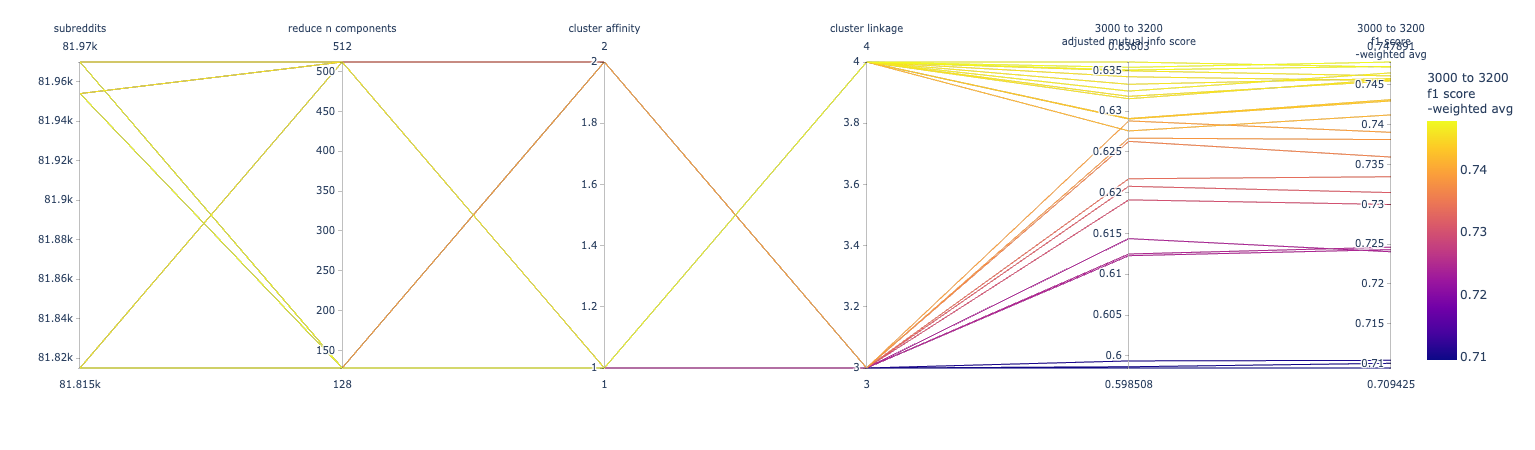

,3000 to 3200<br>adjusted mutual info score<br>,3000 to 3200<br>f1 score<br>-weighted avg<br><br>
cluster linkage,,
3,0.614925,0.725903
4,0.632536,0.745429


In [73]:
l_cols_plot_raw_ = l_parallel_params + l_parallel_metrics_3k
l_cols_plot_clean_ = [rename_col_for_display(c) for c in l_cols_plot_raw_]
df_plot_ = (
    df_mlf_clustering_candidates
    [l_cols_plot_raw_]
    .fillna({'params._pipe-reduce__n_components': 512, 'params._pipe-normalize__norm': 'None'})  # for SVD nulls & norm nulls
    .rename(columns={c: rename_col_for_display(c) for c in l_cols_plot_raw_})
    .reset_index(drop=True)
    .copy()
)
# remap cluster linkage so it shows up in plot
col_linkage_clean = 'cluster linkage'
col_affinity_clean = 'cluster affinity'
col_comp_clean = 'reduce n components'

df_plot_[col_linkage_clean] = df_plot_[col_linkage_clean].replace(d_linkage_to_num)
df_plot_[col_affinity_clean] = df_plot_[col_affinity_clean].replace(d_affinity_to_num)
df_plot_[col_comp_clean] = df_plot_[col_comp_clean].astype(int).replace(d_comp_to_num)
print(f"Linkage names:\n  {d_num_to_linkage}")
print(f"Affinity names:\n  {d_num_to_affinity}")
print(f"Component names:\n  {d_num_to_comp}")

# apply filters
df_plot_ = df_plot_[df_plot_[col_linkage_clean] != d_linkage_to_num['average']].reset_index(drop=True)
# df_plot_ = df_plot_[df_plot_[col_comp_clean] != 2].reset_index(drop=True)

fig = px.parallel_coordinates(
    df_plot_,
    color=l_cols_plot_clean_[-1],
    # dimensions=l_cols_plot_clean_,
    # labels={},
    # color_continuous_scale=px.colors.diverging.Tealrose,
    # color_continuous_midpoint=2
)
fig.show()

display(
    df_plot_.groupby([col_linkage_clean])[l_cols_plot_clean_[-2:]].mean()
)

### Filter to only runs with over 49k rows

Focus on these because we'd prefer a model with more coverage

Linkage names:
  {4: 'ward', 3: 'complete', 2: 'average', 1: 'single'}
Affinity names:
  {2: 'cosine', 1: 'euclidean'}
Component names:
  {512: 'None', 2: 2, 50: 50}
(12, 9)


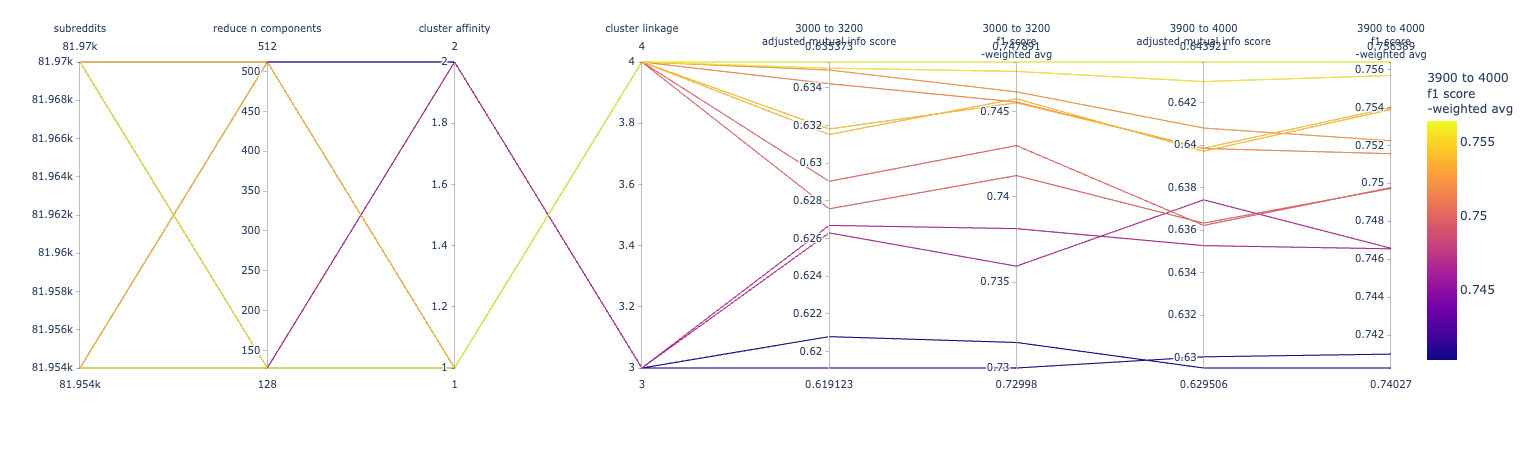

In [77]:
l_cols_plot_raw_ = l_parallel_params + l_parallel_metrics_3k + l_parallel_metrics_4k
l_cols_plot_clean_ = [rename_col_for_display(c) for c in l_cols_plot_raw_]
df_plot_ = (
    df_mlf_clustering_candidates
    [df_mlf_clustering_candidates['metrics.filtered_embeddings-n_rows'] >= 81950]
    [l_cols_plot_raw_]
    .fillna({'params._pipe-reduce__n_components': 512, 'params._pipe-normalize__norm': 'None'})  # for SVD nulls & norm nulls
    .rename(columns={c: rename_col_for_display(c) for c in l_cols_plot_raw_})
    .reset_index(drop=True)
)
# remap cluster linkage so it shows up in plot
col_linkage_clean = 'cluster linkage'
col_affinity_clean = 'cluster affinity'
col_comp_clean = 'reduce n components'

df_plot_[col_linkage_clean] = df_plot_[col_linkage_clean].replace(d_linkage_to_num)
df_plot_[col_affinity_clean] = df_plot_[col_affinity_clean].replace(d_affinity_to_num)
df_plot_[col_comp_clean] = df_plot_[col_comp_clean].astype(int).replace(d_comp_to_num)
print(f"Linkage names:\n  {d_num_to_linkage}")
print(f"Affinity names:\n  {d_num_to_affinity}")
print(f"Component names:\n  {d_num_to_comp}")

# apply filters
df_plot_ = df_plot_[df_plot_[col_linkage_clean] != d_linkage_to_num['average']].reset_index(drop=True)
#  Exclude euclidean + (non-ward)
df_plot_ = df_plot_[
    (df_plot_[col_linkage_clean] == d_linkage_to_num['ward']) |
    (
        (df_plot_[col_linkage_clean] != d_linkage_to_num['ward']) &
        (df_plot_[col_affinity_clean] != d_affinity_to_num['euclidean'])
    )
].reset_index(drop=True)
print(df_plot_.shape)

df_top_runs = df_plot_.copy()

fig = px.parallel_coordinates(
    df_plot_,
    color=l_cols_plot_clean_[-1],
    # dimensions=l_cols_plot_clean_,
    # labels={},
    # color_continuous_scale=px.colors.diverging.Tealrose,
    # color_continuous_midpoint=2
)
fig.show()

## Create masks to find top runs

`Ward` linkage (#4) gets the best score followed by `complete` linkage (#2).

Find runs that are above the mean of linkage=2 (complete linkage). Use these params as the primary search space for v0.5.0.

In [78]:
df_top_runs.shape

(12, 9)

In [79]:
display(
    df_top_runs.groupby([col_linkage_clean])[l_cols_plot_clean_[-4:]].mean()
)

,3000 to 3200<br>adjusted mutual info score<br>,3000 to 3200<br>f1 score<br>-weighted avg<br><br>,3900 to 4000<br>adjusted mutual info score<br>,3900 to 4000<br>f1 score<br>-weighted avg<br><br>
cluster linkage,,,,
3,0.623226,0.733883,0.633059,0.743600
4,0.632443,0.745300,0.639964,0.752906


In [91]:
c_f1_pt_weighted_3k = 'metrics.primary_topic-3000_to_3200-f1_score-weighted_avg'
c_f1_pt_weighted_4k = 'metrics.primary_topic-3900_to_4000-f1_score-weighted_avg'
c_subreddits_filtered = 'metrics.filtered_embeddings-n_rows'

mask_sub_coverage = (
    df_mlf_clustering_candidates[c_subreddits_filtered] >= 81970
)

mask_top_metrics = (
    (df_mlf_clustering_candidates[c_f1_pt_weighted_3k] >= 0.733) &
    (df_mlf_clustering_candidates[c_f1_pt_weighted_4k] >= 0.743) 
)

print(mask_top_metrics.sum())

print((mask_sub_coverage & mask_top_metrics).sum())

15
5


In [92]:
l_cols_to_drop = [
    'artifact_uri',
    'start_time',
    'end_time',
]

l_cols_to_drop = (
    l_cols_to_drop + 
    [c for c in cols_with_multiple_vals if 'metrics.memory_' in c] +
    [c for c in cols_with_multiple_vals if 'metrics.model_fit' in c] +
    [c for c in cols_with_multiple_vals if 'metrics.optimal_k' in c]
)

In [93]:
df_top_runs_full = (
    df_mlf_clustering_candidates
    [mask_sub_coverage & mask_top_metrics]
    .sort_values(by=l_cols_plot_raw_[::-1][:-2], ascending=False)
    [sorted(cols_with_multiple_vals)]
    .drop(l_cols_to_drop, axis=1)
)
df_top_runs_full.shape

(5, 225)

In [94]:
l_parallel_params = [
    'metrics.filtered_embeddings-n_rows',  # Might not be a parameter to tune anymore (n_minimumn # of posts in subreddit)
    'params._pipe-normalize__norm', 
    'params._pipe-reduce__n_components',
    'params._pipe-cluster__affinity',
    'params._pipe-cluster__linkage',
]

for c_ in l_parallel_params:
    display(
        value_counts_and_pcts(
            df_top_runs_full,
            [c_]
        )
    )

,count,percent,cumulative_percent
metrics.filtered_embeddings-n_rows,,,
81970.0,5,100.0%,100.0%


,count,percent,cumulative_percent
params._pipe-normalize__norm,,,
null,3,60.0%,60.0%
l2,2,40.0%,100.0%


,count,percent,cumulative_percent
params._pipe-reduce__n_components,,,
128,3,60.0%,60.0%
null,2,40.0%,100.0%


,count,percent,cumulative_percent
params._pipe-cluster__affinity,,,
euclidean,4,80.0%,80.0%
cosine,1,20.0%,100.0%


,count,percent,cumulative_percent
params._pipe-cluster__linkage,,,
ward,4,80.0%,80.0%
complete,1,20.0%,100.0%


In [95]:
value_counts_and_pcts(
    df_top_runs_full,
    [c for c in l_parallel_params if c_subreddits_filtered not in c]
)

In [96]:
value_counts_and_pcts(
    df_top_runs_full,
    [c_subreddits_filtered]
)

,count,percent,cumulative_percent
metrics.filtered_embeddings-n_rows,,,
81970.0,5,100.0%,100.0%


### All runs

In [100]:
(
    df_mlf_clustering_candidates.fillna('None')
    .groupby([c for c in l_parallel_params if c_subreddits_filtered not in c])
    .agg(
        **{
            'run_id_count': ('run_id', 'nunique'),
            c_f1_pt_weighted_3k: (c_f1_pt_weighted_3k, 'mean'),
            c_f1_pt_weighted_4k: (c_f1_pt_weighted_4k, 'mean'),
        }
    )
    .sort_values(by=c_f1_pt_weighted_4k, ascending=False)
)

run_id_count  metrics.primary_topic-3000_to_3200-f1_score-weighted_avg  metrics.primary_topic-3900_to_4000-f1_score-weighted_avg
params._pipe-normalize__norm params._pipe-reduce__n_components params._pipe-cluster__affinity params._pipe-cluster__linkage                                                                                                                                  
l2                           128                               euclidean                      ward                                      3                                                  0.747494                                                  0.755914
                             None                              euclidean                      ward                                      3                                                  0.745921                                                  0.753966
None                         128                               euclidean                      ward                                      3                                                  0.745835                                                  0.752326
                             None                              euclidean                      ward                                      3                                                  0.742467                                                  0.749905
                             128                               cosine                         complete                                  3                                                  0.737710                                                  0.747407
                             None                              cosine                         complete                                  3                                                  0.731640                                                  0.741200
                             128                               euclidean                      complete                                  3                                                  0.724319                                                  0.734804
                             None                              euclidean                      complete                                  3                                                  0.709943                                                  0.721995
                             128                               cosine                         average                                   3                                                  0.703436                                                  0.718780
                             None                              cosine                         average                                   3                                                  0.683098                                                  0.700946
                             128                               euclidean                      average                                   3                                                  0.657951                                                  0.688601
                             None                              euclidean                      average                                   3                                                  0.498767                                                  0.576572

In [101]:
(
    df_mlf_clustering_candidates.fillna('None')
    .groupby(c_subreddits_filtered)
    .agg(
        **{
            'run_id_count': ('run_id', 'nunique'),
            c_f1_pt_weighted_3k: (c_f1_pt_weighted_3k, 'mean'),
            c_f1_pt_weighted_4k: (c_f1_pt_weighted_4k, 'mean'),
        }
    )
    .sort_values(by=c_f1_pt_weighted_4k, ascending=False)
)

,run_id_count,metrics.primary_topic-3000_to_3200-f1_score-weighted_avg,metrics.primary_topic-3900_to_4000-f1_score-weighted_avg
metrics.filtered_embeddings-n_rows,,,
81815.0,12,0.704044,0.720839
81954.0,12,0.702121,0.720313
81970.0,12,0.700981,0.719453


## Pick best model

It looks like the reduce step with `n_components=128` slightly boosts performance. 

Picked model's `run_id`:
```
8da1ce07d7214ea1a384b445f6d5db5d
```

NOTE: For the next iteration, we should get these metrics using k-fold validation and use the mean+std instead of a single score.

### Only top runs

In [98]:
(
    df_top_runs_full.fillna('None')
    .groupby([c for c in l_parallel_params if c_subreddits_filtered not in c] + ['run_id'])
    .agg(
        **{
            'run_id_count': ('run_id', 'nunique'),
            c_f1_pt_weighted_3k: (c_f1_pt_weighted_3k, 'mean'),
            c_f1_pt_weighted_4k: (c_f1_pt_weighted_4k, 'mean'),
        }
    )
    .sort_values(by=c_f1_pt_weighted_4k, ascending=False)
)

run_id_count  metrics.primary_topic-3000_to_3200-f1_score-weighted_avg  metrics.primary_topic-3900_to_4000-f1_score-weighted_avg
params._pipe-normalize__norm params._pipe-reduce__n_components params._pipe-cluster__affinity params._pipe-cluster__linkage run_id                                                                                                                                                            
l2                           128                               euclidean                      ward                          8da1ce07d7214ea1a384b445f6d5db5d             1                                                  0.747339                                                  0.755680
                             None                              euclidean                      ward                          5273f92619bf4b5da9b9cc574f55c6eb             1                                                  0.745501                                                  0.753984
None                         128                               euclidean                      ward                          addacec7e1a44aa8a9aec86dab037a6f             1                                                  0.745547                                                  0.751558
                             None                              euclidean                      ward                          174515870b48479eb9c37aadd27667c2             1                                                  0.741242                                                  0.749732
                             128                               cosine                         complete                      23e6f694513949f38f52e211cf721afb             1                                                  0.738138                                                  0.746549

In [99]:
(
    df_top_runs_full.fillna('None')
    .groupby(c_subreddits_filtered)
    .agg(
        **{
            'run_id_count': ('run_id', 'nunique'),
            c_f1_pt_weighted_3k: (c_f1_pt_weighted_3k, 'mean'),
            c_f1_pt_weighted_4k: (c_f1_pt_weighted_4k, 'mean'),
        }
    )
    .sort_values(by=c_f1_pt_weighted_4k, ascending=False)
)

,run_id_count,metrics.primary_topic-3000_to_3200-f1_score-weighted_avg,metrics.primary_topic-3900_to_4000-f1_score-weighted_avg
metrics.filtered_embeddings-n_rows,,,
81970.0,5,0.743554,0.751501
